In [1]:
from matplotlib import pyplot as plt

from jwave.geometry import Domain
from jwave import operators as jops
from jwave.core import operator
from jax import numpy as jnp
import jax

# Heterogeneous steady-state heat equation

We want to solve

$$
(\nabla^2 - k^2)u = s
$$

in 2D. We further assume zero Dirichlet boundary conditions (uninsulated).

In [2]:
domain = Domain((128,128), (1., 1.))

# This is not the optimal FFT laplacian. Should add a new primitive
def laplacian(u):
    return jops.sum_over_dims(jops.diag_jacobian(jops.gradient(u)))

@operator()
def heat_eq(u, k):
    return laplacian(u) - (k**2)*u

In [27]:
from jwave.discretization import RealFourierSeries
from jwave.core import Field

# Initialize discretizations
fourier_discr = RealFourierSeries(domain)

# Initialize parameters (we already have the PML parameters)
u_fourier_params = fourier_discr.empty_field()
src_fourier_params = u_fourier_params.at[60:90, 40:70].set(1.)  # Source field, using Fourier discretization
k_fourier_params = u_fourier_params                # Uniform SoS of 1.
k_fourier_params = k_fourier_params.at[20:40,20:50].set(.05)
k_fourier_params = k_fourier_params.at[20:100,85:105].set(.1)

# Create fields
u = Field(fourier_discr, params=u_fourier_params, name='u')
k = Field(fourier_discr, params=k_fourier_params, name='k')
src = Field(fourier_discr, params=src_fourier_params, name='src')

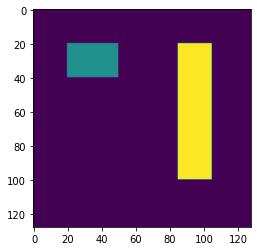

In [28]:
plt.imshow(k_fourier_params)

In [29]:
Hu = heat_eq(u=u, k=k)

print(Hu)

DiscretizedOperator :: [RealFourierSeries], ['_zY'] 

 Input fields: ('u', 'k')

Globals: {'shared': {'FFTGradient': {'k_vec': [DeviceArray([0.        , 0.04908739, 0.09817477, 0.14726216, 0.19634955,
             0.24543694, 0.2945243 , 0.34361172, 0.3926991 , 0.44178647,
             0.49087387, 0.5399613 , 0.5890486 , 0.638136  , 0.68722343,
             0.7363108 , 0.7853982 , 0.8344856 , 0.88357294, 0.93266034,
             0.98174775, 1.0308352 , 1.0799226 , 1.1290098 , 1.1780972 ,
             1.2271847 , 1.276272  , 1.3253595 , 1.3744469 , 1.4235342 ,
             1.4726216 , 1.521709  , 1.5707964 , 1.6198838 , 1.6689712 ,
             1.7180586 , 1.7671459 , 1.8162333 , 1.8653207 , 1.9144081 ,
             1.9634955 , 2.0125828 , 2.0616703 , 2.1107576 , 2.159845  ,
             2.2089324 , 2.2580197 , 2.3071072 , 2.3561945 , 2.405282  ,
             2.4543693 , 2.5034568 , 2.552544  , 2.6016314 , 2.650719  ,
             2.6998062 , 2.7488937 , 2.797981  , 2.8470683 , 2.896155

In [30]:
# Make the computational graph
Hu = heat_eq(u=u, k=k)
global_params = Hu.get_global_params()

# hack to force BC using padding
small_src = src_fourier_params[1:-1,1:-1,:]
@jax.jit
def heat_func(u):
    u = jnp.pad(u,((1,1),(1,1),(0,0)))

    op_image = Hu.get_field_on_grid(0)(
        global_params,
        {"u":u, "k":k_fourier_params}
    )
    
    return op_image[1:-1,1:-1,:]

In [31]:
from jax.scipy.sparse.linalg import gmres
from functools import partial

sol, _ = gmres(heat_func, -small_src, maxiter=1000, restart=25)

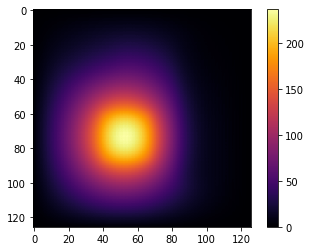

In [32]:
plt.imshow(sol, cmap="inferno", vmin=0.)
plt.colorbar()